# Functional Task Determination Using Deep Learning
Preliminary Exploration of the Code


In [20]:
# Importing necessary libraries
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf

# NIfTI Files
Neuroimaging Informatics Technology Initiative

In [21]:
my_sample = nib.load('ds114_sub009_t2r1.nii')
my_sample.shape

(64, 64, 30, 173)

In [22]:
my_sample.affine

array([[  -4.        ,    0.        ,    0.        ,  124.2440033 ],
       [   0.        ,    3.93453455,    0.72072268, -103.44968414],
       [   0.        ,   -0.72071975,    3.93455052,  -33.49285889],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [23]:
samp_img = my_sample.get_fdata()

In [24]:
samp_img.shape

(64, 64, 30, 173)

# Saving NIfTI slices as 2D png for Deep Learning
Not sure if this is the best way to do this, but this is one method that works

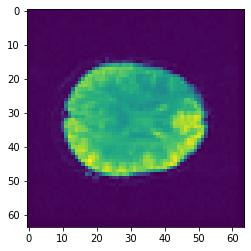

In [25]:
plt.imshow(samp_img[:,:,15,86])
plt.savefig('my_test_slice.png')

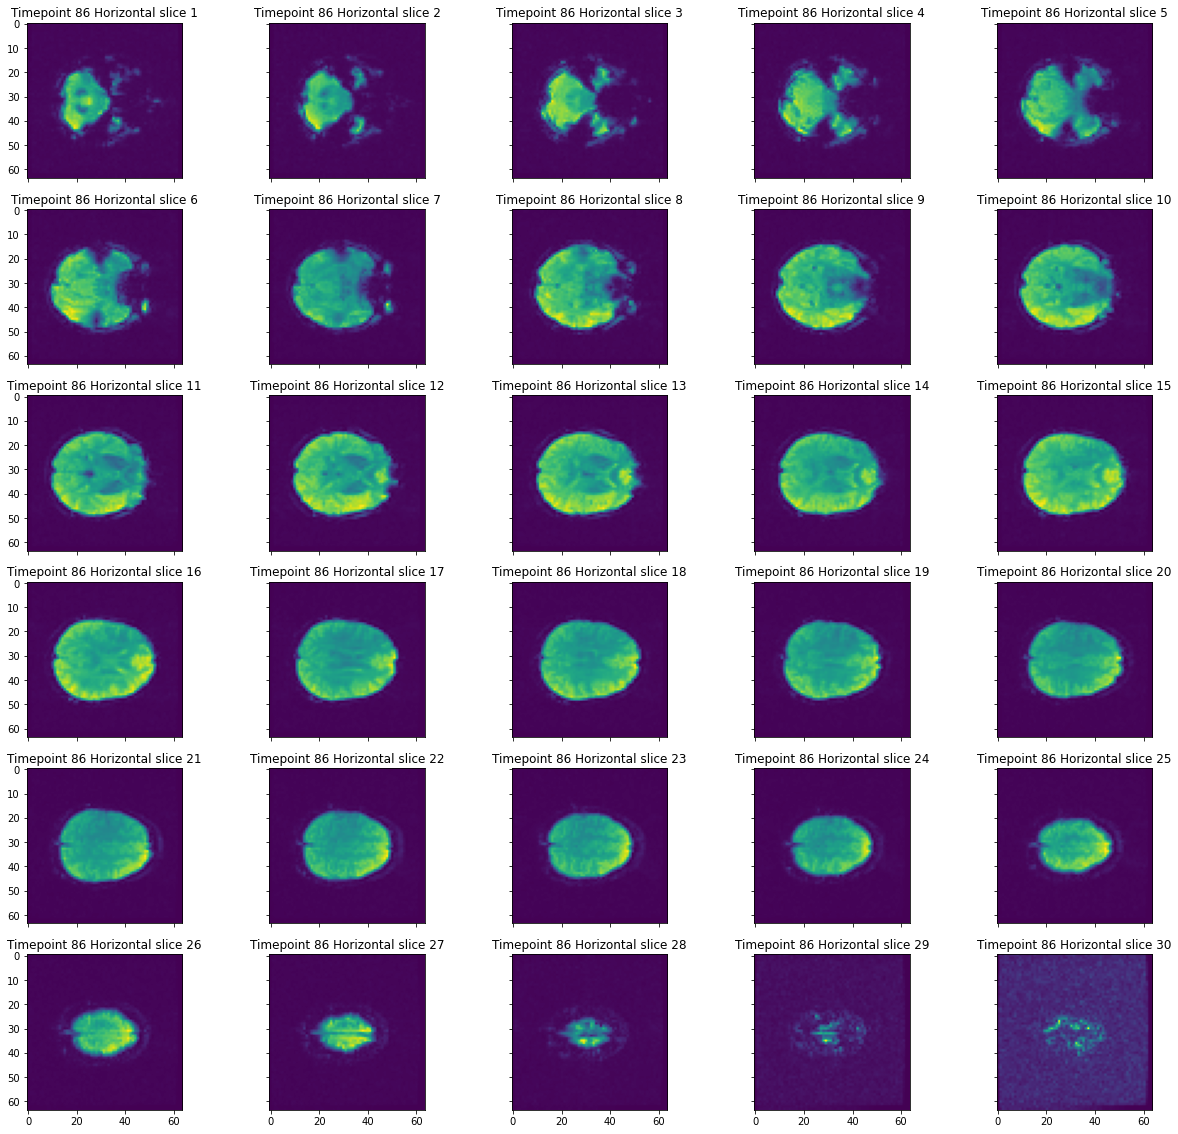

In [26]:
#Select ~Halfway Point
time_halfway = samp_img[:,:,:,86]

#Display Different Slices in z axis at Halfway Point
fig, axs = plt.subplots(6,5, sharex = True, sharey = True)
fig.set_size_inches(21, 20)
for i, axs in enumerate(axs.flat):
    axs.imshow(time_halfway[:,:,i])
    axs.set_title("Timepoint 86 Horizontal slice "+str(i+1))
    
    

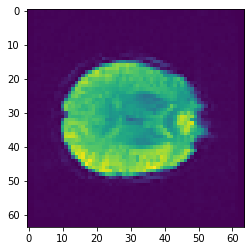

In [27]:
#Maybe I like slice 12 because it gives a good view of the ventricles 
plt.imshow(time_halfway[:,:,12])
plt.savefig('halfway_slice_13.png')

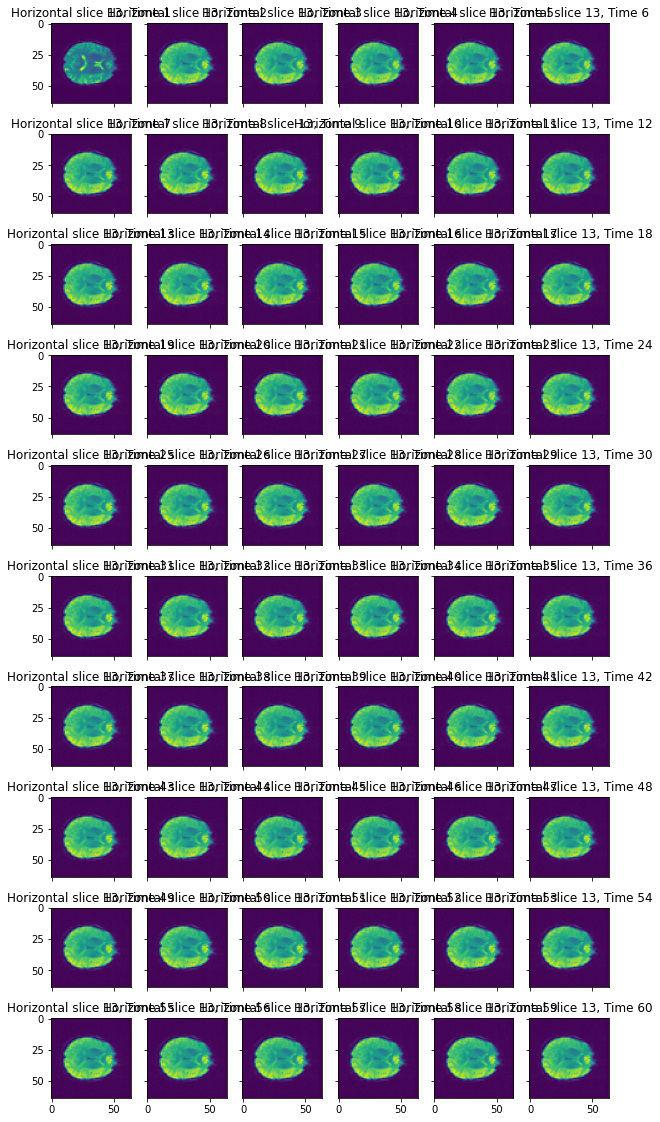

In [28]:
#Show this slice over the first minute of the scan

fig, axs = plt.subplots(10,6, sharex = True, sharey = True)
fig.set_size_inches(10, 20)
for i, axs in enumerate(axs.flat):
    axs.imshow(samp_img[:,:,12,i])
    axs.set_title("Horizontal slice 13, Time "+str(i+1))

# Beginnings of Voxel Intensity Normalization
First, we reshape the data into series of volumes at different time points

In [29]:
vol_time_samp = samp_img.reshape(np.prod(samp_img.shape[:-1]), samp_img.shape[-1])
vol_time_samp.shape

(122880, 173)

Now we take the standard deviation of each voxel across time 


In [30]:
std_vox = np.std(vol_time_samp, axis = 1)
std_vox.shape

(122880,)

Reshape back to xyz dimensions. No time dimension, because data was aggregated across time

In [31]:
std_img = std_vox.reshape(64,64,30)

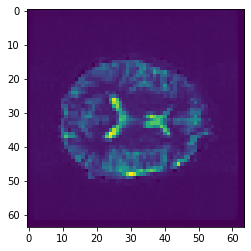

In [32]:
plt.imshow(std_img[:,:,12])

# Normalize with Z Score

In [ ]:
half_vol = time_halfway.reshape(np.prod(time_halfway.shape))
half_vol.shape

In [ ]:
half_z_vox = stats.zscore(half_vol)
half_z_vox.shape

In [ ]:
half_z_img = half_z_vox.reshape(64,64,30)

In [ ]:
plt.imshow(half_z_img[:,:,12])

May look the same, but if we investigate the intensities, we see we now have a zero mean unit variance

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,15)
axs[0].imshow(time_halfway[:,:,12])
axs[1].imshow(half_z_img[:,:,12])

In [ ]:
print(time_halfway[32,32,12])
print(half_z_img[32,32,12])

# Z-score with a brain mask
- Brain mask is a binary array that lets us ignore the empty space outside of the brain
- Useful for z scores 

In [35]:
mri = nib.load('T1.nii.gz')
mri_img = mri.get_fdata()
mri.shape

(290, 320, 208)

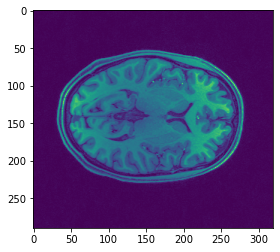

In [36]:
plt.imshow(mri_img[:,:,104])

In [37]:
#Skull Stripped Image
extract = nib.load('T1_brain.nii.gz')
extract_img = extract.get_fdata()
extract.shape

(290, 320, 208)

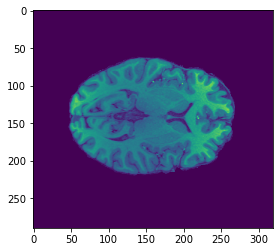

In [38]:
plt.imshow(extract_img[:,:,104])

In [39]:
mask = nib.load('T1_brain_mask.nii.gz')
mask_img = mask.get_fdata()
mask.shape

(290, 320, 208)

1.0


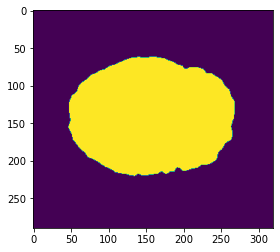

In [40]:
print(np.max(mask_img))
plt.imshow(mask_img[:,:,104])

In [41]:
mask_img = mask_img.astype(bool)

In [42]:
brain_masked = extract_img[mask_img]
brain_masked.shape

(2718075,)

In [43]:
z_brain = stats.zscore(brain_masked)


In [44]:
unmasked = np.zeros(mask_img.shape, dtype = z_brain.dtype)
unmasked.shape

(290, 320, 208)

In [45]:
unmasked[mask_img] = z_brain

May look the same, but if we investigate the intensities, we see we now have a zero mean unit variance

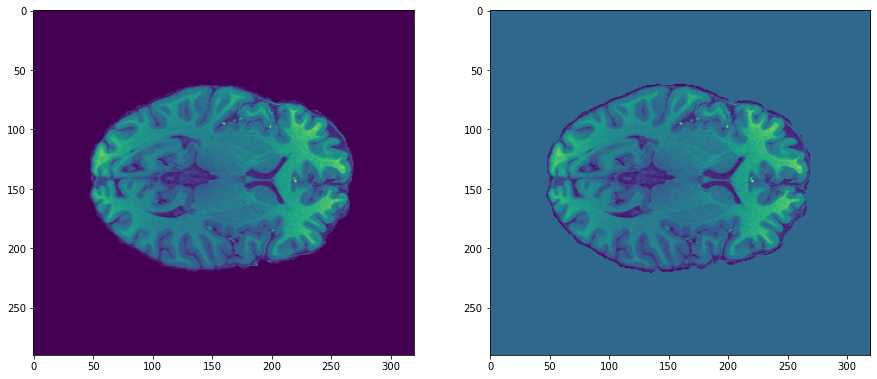

In [46]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(15,15)
axs[0].imshow(extract_img[:,:,104])
axs[1].imshow(unmasked[:,:,104])


In [47]:
print(extract_img[145,160,104])
print(unmasked[145,160,104])

219.0
0.04876821264263133


# Beginnings of Spatial Normalization
- Not every image is taken at the same orientation
- The voxel coordinates of time_halfway are specific to that scan and are therefore somewhat arbitrary
- Need to keep track of voxel coordinates in relation to some reference space

# Reference Spaces
- Scanner XYZ
-- relative to machine
- Scanner RAS+ (right, anterior, superior)(all the positive values)
-- relative to subject regardless or orientation of subject in the machine

# Need function to transform Voxel Coordinates into Reference Coordinates
- Affine is a matrix that can be applied to a coordinate in voxel space to give us coordinates in a reference space
- info stored in the NIfTI file

In [49]:
aff = my_sample.affine
aff

array([[  -4.        ,    0.        ,    0.        ,  124.2440033 ],
       [   0.        ,    3.93453455,    0.72072268, -103.44968414],
       [   0.        ,   -0.72071975,    3.93455052,  -33.49285889],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

In [50]:
#Applying affine to a coordinate gives us a new set of coordinates
nib.affines.apply_affine(aff,[32,32,15])

array([-3.7559967 , 33.26626158,  2.46236682])

# Starting to Build a DL Model

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

A Very Basic Model: Image Classification (based on TF website)
- Dimensions of slices are (64, 64)
- Eventually we want our images to be classified as corresponding to one of three fmri tasks (last layer)

In [ ]:
# A Very Basic Model
my_fmri_model_1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64)), #Reshaping our slices
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3)                       #Returns a logit array of our 3 categories 
])

Compiling the Model (Based on TF Website)

In [ ]:
my_fmri_model_1.compile(optimizer='adam',   #Updates model based on loss function below
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])         #Monitoring based on fraction of correct classifications

# Updating Model Based on Previous Literature
Deep learning of fMRI big data: a novel approach to subject-transfer decoding (Koyamade et al., 2015)
- Stochastic Gradient Descent as optimizer
- ReLU   Rectified Linear Unit - popular activation function: Returns the input value if input value is > 0, Returns 0.0 if input value is < 0 
- Dropout technique - randomly skipping neurons to help avoid over-fitting